# Parte 2

# Analisador de palavras


### Carregamento de pacotes

Em primeiro lugar serão carregados os pacotes necessários para a execução do programa.

In [4]:
library(tm)        # Para fazer a filtragem do texto (por exemplo, remover palavras vazias, números, ...)
library(e1071)     # Para o modelo naiveBayes e svm
library(dplyr)     # Para utilizar o operador %>%
library(wordcloud) # Para plotar nuvem de palavras.

### Leitura e formatação dos dados

In [5]:
# Lê os dados do rotten tomatoes.
negative <- readLines('/home/glauber/Dropbox/Rprojects/CaseStudies/Data/rt-polarity/rt-polarity.neg', warn = FALSE)
positive <- readLines('/home/glauber/Dropbox/Rprojects/CaseStudies/Data/rt-polarity/rt-polarity.pos', warn = FALSE)

In [6]:
# Agrupa os textos referentes a sentimentos positivos e negativos em um dataframe.
text <- c(positive, negative)
class <- c(rep('positive', length(positive)), rep('negative', length(negative)))
df <- data.frame(text, class)

In [7]:
# Converte a classe da coluna text referente ao dataframe df
df$text <- as.character(df$text)

In [8]:
# Mostra como o dado esta estruturado
glimpse(df)

Observations: 10,662
Variables: 2
$ text  <chr> "the rock is destined to be the 21st century's new \" conan \...
$ class <fctr> positive, positive, positive, positive, positive, positive, ...


In [9]:
# Embaralha o dado
set.seed(1)
df <- df[sample(nrow(df)), ]
glimpse(df)


Observations: 10,662
Variables: 2
$ text  <chr> "a savage john waters-like humor that dances on the edge of t...
$ class <fctr> positive, positive, negative, negative, positive, negative, ...


## Tokenização - Saco de palavras

Nesta parte do programa cada palavra de um documento será representada como um token e cada documento como um vetor de tokens.

In [10]:
# Prepara o corpus de todos os documentos contidos no dataframe.
corpus <- Corpus(VectorSource(df$text))
corpus

<<VCorpus (documents: 10662, metadata (corpus/indexed): 0/0)>>

In [9]:
# Inspeção do objeto corpus
inspect(corpus[1:3])

<<VCorpus (documents: 3, metadata (corpus/indexed): 0/0)>>

[[1]]
<<PlainTextDocument (metadata: 7)>>
a savage john waters-like humor that dances on the edge of tastelessness without ever quite falling over . 

[[2]]
<<PlainTextDocument (metadata: 7)>>
obligada para impotentes , daneses , camareras italianas , profesores de idiomas , y todo aquel que desee una lengua para expresar su amor . 

[[3]]
<<PlainTextDocument (metadata: 7)>>
it's not a bad premise , just a bad movie . 



### Limpeza do dado

Serão eliminados números, pontuações, espaços em branco e as palavras terão suas letras convertidas 
para letras minúsculas. Além disso, as palavras vazias (*stop words*) serão removidas, pois não expressam sentimentos. Por fim, será aplicada uma técnica de *stemming* com o objetivo de converter palavras como
*teach*, *teacher*, *teaching* e *teached* para seu radical *teach*.

In [11]:
# Lista de palavras vazias utilizas pelo MySQL
wordsToRemove <- readLines('/home/glauber/Dropbox/Rprojects/CaseStudies/Data/myStopwords.txt')
wordsToRemove

[1] "a"             "able"          "about"         "above"        
  [5] "abst"          "accordance"    "according"     "accordingly"  
  [9] "across"        "act"           "actually"      "added"        
 [13] "adj"           "affected"      "affecting"     "affects"      
 [17] "after"         "afterwards"    "again"         "against"      
 [21] "ah"            "all"           "almost"        "alone"        
 [25] "along"         "already"       "also"          "although"     
 [29] "always"        "am"            "among"         "amongst"      
 [33] "an"            "and"           "announce"      "another"      
 [37] "any"           "anybody"       "anyhow"        "anymore"      
 [41] "anyone"        "anything"      "anyway"        "anyways"      
 [45] "anywhere"      "apparently"    "approximately" "are"          
 [49] "aren"          "arent"         "arise"         "around"       
 [53] "as"            "aside"         "ask"           "asking"       
 [57] "at"            "auth"          "available"     "away"         
 [61] "awfully"       "b"             "back"          "be"           
 [65] "became"        "because"       "become"        "becomes"      
 [69] "becoming"      "been"          "before"        "beforehand"   
 [73] "begin"         "beginning"     "beginnings"    "begins"       
 [77] "behind"        "being"         "believe"       "below"        
 [81] "beside"        "besides"       "between"       "beyond"       
 [85] "biol"          "both"          "brief"         "briefly"      
 [89] "but"           "by"            "c"             "ca"           
 [93] "came"          "can"           "cannot"        "can't"        
 [97] "cause"         "causes"        "certain"       "certainly"    
[101] "co"            "com"           "come"          "comes"        
[105] "contain"       "containing"    "contains"      "could"        
[109] "couldnt"       "d"             "date"          "did"          
[113] "didn't"        "different"     "do"            "does"         
[117] "doesn't"       "doing"         "done"          "don't"        
[121] "down"          "downwards"     "due"           "during"       
[125] "e"             "each"          "ed"            "edu"          
[129] "effect"        "eg"            "eight"         "eighty"       
[133] "either"        "else"          "elsewhere"     "end"          
[137] "ending"        "enough"        "especially"    "et"           
[141] "et-al"         "etc"           "even"          "ever"         
[145] "every"         "everybody"     "everyone"      "everything"   
[149] "everywhere"    "ex"            "except"        "f"            
[153] "far"           "few"           "ff"            "fifth"        
[157] "first"         "five"          "fix"           "followed"     
[161] "following"     "follows"       "for"           "former"       
[165] "formerly"      "forth"         "found"         "four"         
[169] "from"          "further"       "furthermore"   "g"            
[173] "gave"          "get"           "gets"          "getting"      
[177] "give"          "given"         "gives"         "giving"       
[181] "go"            "goes"          "gone"          "got"          
[185] "gotten"        "h"             "had"           "happens"      
[189] "hardly"        "has"           "hasn't"        "have"         
[193] "haven't"       "having"        "he"            "hed"          
[197] "hence"         "her"           "here"          "hereafter"    
[201] "hereby"        "herein"        "heres"         "hereupon"     
[205] "hers"          "herself"       "hes"           "hi"           
[209] "hid"           "him"           "himself"       "his"          
[213] "hither"        "home"          "how"           "howbeit"      
[217] "however"       "hundred"       "i"             "id"           
[221] "ie"            "if"            "i'll"          "im"           
[225] "immediate"     "immediately"   "importance"    "important"    
[229] "in"  

In [12]:
corpusClean <- corpus %>%
  tm_map(content_transformer(tolower)) %>%      # Converte letras maiúsculas para minúsculas
  tm_map(removeWords, stopwords(kind="en")) %>% # Remove palavras vazias comuns
  tm_map(removeWords, wordsToRemove) %>%        # Remove palavras vazias contidas no objeto wordsToRemove
  tm_map(removePunctuation) %>%                 # Remove pontuações
  tm_map(removeNumbers) %>%                     # Remove números
  tm_map(stemDocument, "english")  %>%          # Técnica Stemming
  tm_map(stripWhitespace)                       # Remove espações em branco do documento

In [13]:
# Matriz represetantação do saco de palavras: colunas são tokens e as linhas representam o número de vezes que a 
# palavra é utilizada por documento (linha do arquivo de entrada)
dtm <- DocumentTermMatrix(corpusClean)

In [14]:
# Inspeção da matriz
inspect(dtm[40:50, 10:15])

<<DocumentTermMatrix (documents: 11, terms: 6)>>
Non-/sparse entries: 0/66
Sparsity           : 100%
Maximal term length: 11
Weighting          : term frequency (tf)

    Terms
Docs abbrevi abc abderrahman abdul abel aberr
  40       0   0           0     0    0     0
  41       0   0           0     0    0     0
  42       0   0           0     0    0     0
  43       0   0           0     0    0     0
  44       0   0           0     0    0     0
  45       0   0           0     0    0     0
  46       0   0           0     0    0     0
  47       0   0           0     0    0     0
  48       0   0           0     0    0     0
  49       0   0           0     0    0     0
  50       0   0           0     0    0     0


## Análise da frequência das palavras mais utilizadas

In [15]:
mat <- as.matrix(dtm) # Convert o objeto dtm para a classe matrix
freqPos <- sort(colSums(mat[df$class == 'positive', ]), decreasing = TRUE)
freqNeg <- sort(colSums(mat[df$class == 'negative', ]), decreasing = TRUE)

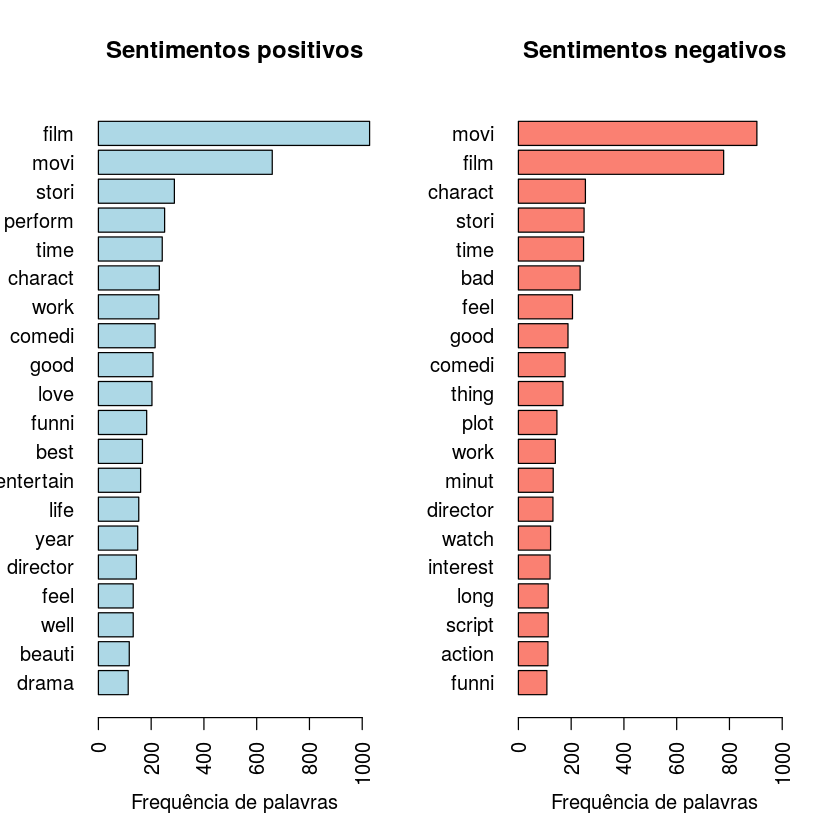

In [16]:
par(mfrow = c(1,2))

xlim <- c(0, max(c(freqPos, freqNeg)))

barplot(rev(freqPos[1:20]), las = 2, names.arg = rev(names(freqPos)[1:20]), xlim = xlim,
        col = "lightblue", main = "Sentimentos positivos",
        xlab = "Frequência de palavras", horiz = TRUE)

barplot(rev(freqNeg[1:20]), las = 2, names.arg = rev(names(freqNeg)[1:20]), xlim = xlim,
        col = "salmon", main = "Sentimentos negativos",
        xlab = "Frequência de palavras", horiz = TRUE)

As figuras acima apresentam as 20 palavras mais frequentes para os sentimentos positivos (esquerda) e 
negativos (direita). Percebemos que as palavras movi e film são as mais frequentes em ambos os gráficos. No gráfico à direita (sentimentos negativos), percebe-se palavras como charact, stori e comedi indicando aspectos
referentes aos filmes que estão sendo críticados. No gráfico à esquerda (sentimentos positivos) notamos as mesmas palavras, no entanto, aqui deve estar associadas a elogios.

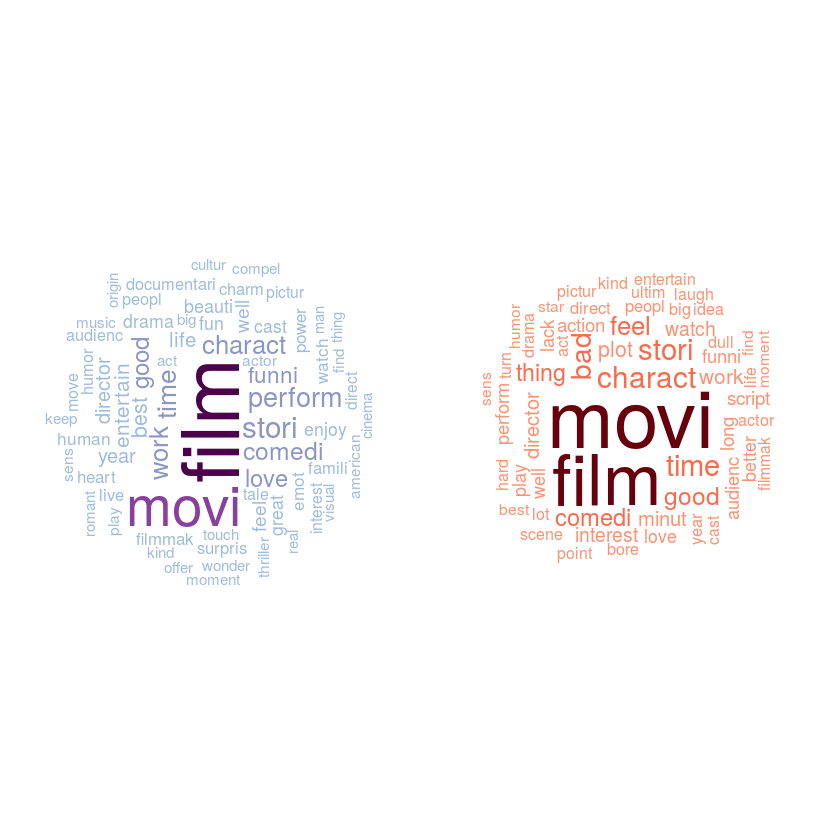

In [17]:
# Nuvem de palavras
par(mfrow = c(1,2))

wordcloud(freq = as.vector(freqPos), words = names(freqPos),random.order = FALSE,
          min.freq = 70, max.words=200,rot.per = 0.35,
          random.color = FALSE, colors = brewer.pal(9, 'BuPu')[4:9])

wordcloud(freq = as.vector(freqNeg), words = names(freqNeg), random.order = FALSE,
          min.freq = 70, max.words=200, rot.per = 0.35,
          random.color = FALSE, colors = brewer.pal(9, 'Reds')[4:9])

O gráfico de nuvem de palavras mostrado logo acima apresenta as palavras mais frequentes 
associadas a sentimentos positivos (à esquerda em azul) e negativos (à direita em vermelho). O tamanho das
palavras está associado à frequẽncia das mesmas, ou seja, as palavras mais frequêntes tem os maiores tamanhos
enquanto que as menos frequêntes possuem os menores tamanhos. Pode-se notar, por exemplo, que assim como no gráfico de barras as palavras movi e film aparecem em destaque com os maiores tamanhos.

### Associação de palavras

Nesta etapa do script buscamos encontrar palavras correlacionadas com as 5 mais frequentes palavras
refrentes aos sentimentos positive e negativos. Serão consideradas apenas correções superiores a 7%.

In [18]:
# Separa da matriz dtm os sentimentos positivos e negativos
dtmPos <- dtm[df$class == 'positive', ]
dtmNeg <- dtm[df$class == 'negative', ]

In [19]:
# Calcula a correlação entre as palavras referentes a sentimentos positivos
findAssocs(dtmPos, names(freqPos)[1:5], .07)

$film
plagu 
 0.09 

$movi
  substant     cuarón       road thornberri     rugrat  tarantula       anew 
      0.15       0.10       0.10       0.09       0.08       0.08       0.07 
      anti   backhand   biennial     bigbug        cal    depalma    emphasi 
      0.07       0.07       0.07       0.07       0.07       0.07       0.07 
     fetch    hellish     horrid   knockoff      nifti     oddest     pgrate 
      0.07       0.07       0.07       0.07       0.07       0.07       0.07 
      piss      ramif     throat     topbil      twelv 
      0.07       0.07       0.07       0.07       0.07 

$stori
    detect       tell       told       love   simplest  strangest     stripe 
      0.14       0.12       0.12       0.11       0.11       0.11       0.11 
  whodunit      wiser     compel  contribut      shrug aficionado      annal 
      0.11       0.11       0.09       0.09       0.09       0.08       0.08 
     batch cinderella   comingag       lame     specif    stanley unorthodox 
      0.08       0.08       0.08       0.08       0.08       0.08       0.08 
     valid 
      0.08 

$perform
    kinnear        lead        andi  oscarcalib     richest      unemot 
       0.16        0.15        0.12        0.12        0.12        0.12 
      excel      renner     wollter      pacino     piccoli     seldahl 
       0.11        0.11        0.11        0.10        0.10        0.10 
    underst      abbass      anchor        cain      huston      kilmer 
       0.10        0.09        0.09        0.09        0.09        0.09 
     michel        mick oscarworthi parentchild    parmenti   resurrect 
       0.09        0.09        0.09        0.09        0.09        0.09 
    stellar      terrif      wrench      commit       quaid        cast 
       0.09        0.09        0.09        0.08        0.08        0.07 
     except   nicholson        sayl       solid 
       0.07        0.07        0.07        0.07 

$time
conscienti        run  threehour      whale    appoint clockstopp     colour 
      0.13       0.12       0.11       0.11       0.09       0.09       0.09 
    fuller      olivi        pad     preach   reckless    spymovi     wannab 
      0.09       0.09       0.09       0.09       0.09       0.09       0.09 
     spend      worth     loneli       tsai 
      0.08       0.08       0.07       0.07

Logo acima vemos algumas associações interessantes referentes a críticas positivas aos filmes, 
embora as correlação sejam muito baixas, ou seja, essas palavras não foram utilizas nas mesma frase com muita 
frequência.  A palavra "movi" (radical de movie ou movies) é mais utilizada com a palavra substant (radical de 
substantial) e com a palavra cuarón que se refere ao diretor Alfonso Cuarón.

In [20]:
# Calcula a correlação entre as palavras referentes a sentimentos negativos
findAssocs(dtmNeg, names(freqNeg)[1:5], .07)

$movi
leguizamo 
     0.07 

$film
publicist 
     0.07 

$charact
    develop   dimension        main unsympathet        plot         bug 
       0.15        0.15        0.12        0.11        0.10        0.09 
  caricatur      culkin     dilemma       round       studi       vivid 
       0.09        0.09        0.09        0.09        0.09        0.09 
  paperthin        skin       unusu      believ        care     central 
       0.08        0.08        0.08        0.07        0.07        0.07 
     situat 
       0.07 

$stori
fragmentari preliminari        base    individu        true        told 
       0.13        0.13        0.11        0.11        0.11        0.10 
    drumlin   interlock        love        tell 
       0.09        0.09        0.09        0.09 

$time
        run    afterlif        elmo      hostil  majorleagu      repeat 
       0.16        0.12        0.12        0.12        0.12        0.12 
     retali   rewritten underachiev        wast       metal      climax 
       0.12        0.12        0.12        0.11        0.10        0.09 
 clockstopp     stinker        wish        coke       devot       dozen 
       0.09        0.09        0.09        0.08        0.08        0.08 
      dylan       etern     firebal      hearst      integr      machin 
       0.08        0.08        0.08        0.08        0.08        0.08 
       pant    reckless       spend       stoop      urgenc    everlast 
       0.08        0.08        0.08        0.08        0.08        0.07 
       long       spent 
       0.07        0.07

Agora, com relação às críticas negativas, notamos, por exemplo, que a palavra movi é mais associada à palavra 
leguizamo (se refere à John Leguizamo). Novamente, vale destacar que a correlação é muito baixa, o que indica
que essa associação aconteceu muito poucas vezes.

## Modelagem de sentimentos

Nesta parte do códico dois modelos serão treinados a fim de tentar predizer se sentimentos são positivos ou
negativos, dado os preditores. 

### Particionamento do dado em treino (*train*) e teste (*test*).

In [21]:
# Particionamento do dado 90/10: train fica com 90% do dado incial e o test com 10%.
idx <- 1:(nrow(df)*0.9)

dfTrain <- df[idx,]
dfTest <- df[-idx,]

dtmTrain <- dtm[idx,]
dtmTest <- dtm[-idx,]

corpusCleanTrain <- corpusClean[idx]
corpusCleanTest <- corpusClean[-idx]


### Seleção de tokens

Palavras que ocorrem com pouca frequência no texto podem contruibuir para o mal funcionamento dos
modelos estatísticos. Portanto, tokens com frequência menor do que 5 serão removidos das matrizes.

In [22]:
dim(dtmTrain)

[1]  9595 12979

In [23]:
highFreq <- findFreqTerms(dtmTrain, lowfreq = 5)
length(highFreq)

[1] 3234

In [24]:
dtmTrainNew <- DocumentTermMatrix(corpusCleanTrain, control=list(dictionary = highFreq))
dim(dtmTrainNew)

dtmTestNew <- DocumentTermMatrix(corpusCleanTest, control=list(dictionary = highFreq))
dim(dtmTestNew)

[1] 9595 3234

[1] 1067 3234

### Naive Bayes

O método de Bayes considera que os preditores são independentes, o que é considerado como uma desvantagem do método. Entretanto, esse método não é sensível a características irrelevantes e frequentemente apresenta bons resultados, tanto com dados contínuos quanto discretos. É um método simples e portanto rápido para treinar, sendo necessário apenas uma varredura nos dados.

In [25]:
# Treinando o modelo
classifier <- naiveBayes(as.matrix(dtmTrainNew), dfTrain$class)

# Calcula as predições
pred <- predict(classifier, newdata=as.matrix(dtmTestNew) )

# Confusion Matrix
conf <- table("Predição" = pred, "Observação" = dfTest$class )
conf

          Observação
Predição negative positive
  negative      249      231
  positive      298      289

In [26]:
# Acurácia do modelo
round(sum(diag(conf)) / sum(conf) * 100, 2)

[1] 50.42

O modelo Naive Bayes apresentou uma acurácia de 50,42% que é um valor muito baixo. Isso significa que nosso modelo
é somente um pouco melhor do que um chute.

### Boolean feature Multinomial Naive Bayes

É uma variação do método Naive Bayes no qual as frequências dos tokens
são substituídas por 'No' ou 'Yes'. Se uma palavra tem frequência maior que zero é atribuído 'Yes' a ela, caso contrário é atribuído 'No'. Este método assume que a occorrência de uma determinada palavra é mais importante que sua frequência.

In [27]:
# Converte as frequências de palavras em 0 ou 1, rotulados por
# 'No' e 'Yes', respectivamente.
countToLogic <- function(x) {
  y <- ifelse(x > 0, 1, 0)
  y <- factor(y, levels=c(0,1), labels=c("No", "Yes"))
  return(y)
}

In [28]:
# Aplica a função countToLogic nas matrizes de palavras
trainNB <- apply(dtmTrainNew, 2, countToLogic)
testNB <- apply(dtmTestNew, 2, countToLogic)

In [29]:
# Treinando o modelo
classifier <- naiveBayes(trainNB, dfTrain$class, laplace = 1)

# Calcula as predições
pred <- predict(classifier, newdata=testNB)

# Confusion Matrix
conf <- table("Predição" = pred, "Observação" = dfTest$class )
conf

          Observação
Predição negative positive
  negative      419      132
  positive      128      388

In [30]:
# Acurácia do modelo
round(sum(diag(conf)) / sum(conf) * 100, 2)

[1] 75.63

O método boolean feture Multinomial Naive Bayes apresentou uma boa acurácia com um valor 75,63 %, tendo um desempenho melhor que o método Naive Bayes. Este resultado indica que o modelo tende a acertar se o sentimento é positivo ou negativo em 75,63% das vezes.